### Import packages

In [1]:
# Scientific computing
import numpy as np

# Visualisation
import matplotlib.pyplot as plt

# data structure
import pandas as pd

# Import the storage tank Class
from cryoevap.storage_tanks import Tank

# Import Cryogen class
from cryoevap.cryogens import Cryogen

### Define all Variables

In [2]:
# Cylindrical storage tank properties
Q_roof = 0 # Roof heat ingress / W
T_air = 298.15 # Temperature of the environment K

# Set overall heat transfer coefficient through the walls for liquid and vapour
U_L = 2e-1 # W/m2/K
U_V = 2e-1 # W/m2/K

# Specify wall heat partitioning fraction
eta_w= 0.9

# Specify tank operating pressure
P = 100000 # Pa

### Variables of interest

# Vertically orientated cylindrical tank volume
V_tank = 165000 #m^3 | 

# Initial liquid filling / Dimensionless
LFs = [0.3, 0.95] # values of 0.95 and 0.30

# especify compound in the tank
Compound = "methane" # hydrogen, methane, ammonia, nitrogen

# Especify if the data should be saved in the output.xlxs excel
sv = True

In [3]:
# Define evaporation time to simulate
hours = [24 * 30, 24 * 2] #[24 * 2, 24 * 30]
evap_times = [x * 3600 for x in hours]
# helpful variables
mults = [1 , 2 , 3]
# Thickness of the in % of the internal diameter
ST = 1.02

# Show sim duration
print(f"Simulation time: {hours} h")

Simulation time: [720, 48] h


In [4]:
# Define objective function
def BOR_function(a):
    # Update aspect ratio
    # Calculate internal diameter
    d_i = ((4 * V_tank)/(np.pi * a))**(1/3) # internal diameter / m
    d_o = d_i * ST # external diameter / m
    
    # Initialize tank
    mid_tank = Tank(d_i, d_o, V_tank, LF)

    # Set cryogen
    mid_tank.cryogen = Cryogen(name = Compound)
    
    mid_tank.cryogen.set_coolprops(P)

    # Heat flux
    q_b = mult * U_L * (T_air-mid_tank.cryogen.T_sat)  
    
    Q_b_fixed = q_b * mid_tank.A_T
    
    #Set Heat transfer propierties
    mid_tank.set_HeatTransProps(U_L, U_V, T_air, Q_b_fixed, Q_roof, eta_w)

    mid_tank.U_roof = 0
    
    # Define vertical spacing
    # dz = 0.05 # 0.1 0.01 0.001
    # Calculate number of nodes
    
    # n_z = 1 + int(np.round(mid_tank.l_V/dz, 0))

    n_z = 20
    
    # Define dimensionless computational grid
    mid_tank.z_grid = np.linspace(0, 1, n_z)
    
    # Execute simulation
    mid_tank.evaporate(evap_time)
    
    # return BOR
    
    print("a = %.3f, BOR=%.3e" % (a, mid_tank.BOR()))
    
    return mid_tank.BOR()

In [5]:
from scipy.optimize import Bounds, minimize

# Minimum and maximum practical ranges
# of the aspect ratio
bounds = Bounds([0.1], [5])

# Initial Aspect Ratio to optimise
x0 = 1 

# Solution of the optimization 
for mult in mults:
    for LF in LFs:
        for evap_time in evap_times:
            print(f"\nOptimum search for Tank Volume: {V_tank}, Liquid Filling: {LF*100}%, Compound: {Compound}, time: {evap_time/3600} hrs")
            res = minimize(BOR_function, x0, method='trust-constr',tol=1e-8 , options={'verbose': 1}, bounds=bounds)
            
            # Calculate internal diameter for optimum
            d_i = ((4 * V_tank)/(np.pi * res.x[0]))**(1/3) # internal diameter / m
            d_o = d_i * ST # external diameter / m
            
            # Initialize optimum tank
            mid_tank = Tank(d_i, d_o, V_tank, LF)
            
            # Set cryogen
            mid_tank.cryogen = Cryogen(name = Compound)
            
            mid_tank.cryogen.set_coolprops(P)
            
            q_b = mult * U_L * (T_air-mid_tank.cryogen.T_sat) # Heat flux proportional to the T diff of the cryogen.
            
            Q_b_fixed= q_b * mid_tank.A_T
            
            mid_tank.set_HeatTransProps(U_L, U_V, T_air, Q_b_fixed, Q_roof, eta_w)
            
            mid_tank.U_roof = U_V
            
            # Data table
            
            table = [[Compound, mid_tank.V, mid_tank.LF, f"{evap_time/3600} hrs", f"{res.fun}", f"{res.x[0]}",
                        P, T_air, mid_tank.d_i, mid_tank.d_o, mid_tank.l, U_L, U_V, eta_w, mid_tank.Q_b, q_b]]
            
            # structure the data table
            
            data_table = pd.DataFrame(table, columns = ["Cryogen", "Volume", "Liquid Filling","Simulation","BOR","Aspect Ratio"
                                                    , "Pressure (P)", "T_air (K)", "d_i", "d_o", "Height", "U_L", "U_V", "Eta_w","Q_b","q_b"])
            #print(Data_table)
            
            if sv:
                # Send Data table to excel
                # Try to load the existing Excel file
                try:
                    data_excel = pd.read_excel('Final.xlsx')
                    
                    # Append the row
                    data_excel = pd.concat([data_excel, data_table], ignore_index = True)
                    
                    # Save the updated DataFrame back to the Excel file
                    data_excel.to_excel('Final.xlsx', index = False)
                except:
                    #In case the file doesnt exist it is created
                    data_table.to_excel('Final.xlsx', index = False)
                print("\n^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\nData was saved.\n^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
            else:
                print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\nData was not saved.\n^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
                # Print a summary of the optimum if it is found
            if res.success:
                print(f"\nOptimum found for Tank Volume: {V_tank}, Liquid Filling: {LF*100}%, Compound: {Compound}" + 
                      f"\nAspect Ratio = {res.x[0]:.3f}" + f"\nBOR = {res.fun*100:.3f} %")


Optimum search for Tank Volume: 165000, Liquid Filling: 30.0%, Compound: methane, time: 720.0 hrs


/tmp/ipykernel_43114/3277189072.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("a = %.3f, BOR=%.3e" % (a, mid_tank.BOR()))


a = 1.000, BOR=3.921e-03
a = 1.000, BOR=3.921e-03
a = 1.066, BOR=3.951e-03
a = 1.066, BOR=3.951e-03
a = 0.478, BOR=3.795e-03
a = 0.478, BOR=3.795e-03
a = 0.754, BOR=3.823e-03
a = 0.754, BOR=3.823e-03
a = 0.641, BOR=3.794e-03
a = 0.641, BOR=3.794e-03
a = 0.555, BOR=3.785e-03
a = 0.555, BOR=3.785e-03
a = 0.555, BOR=3.785e-03
a = 0.555, BOR=3.785e-03
`gtol` termination condition is satisfied.
Number of iterations: 16, function evaluations: 14, CG iterations: 6, optimality: 5.95e-09, constraint violation: 0.00e+00, execution time: 3.6e+01 s.

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Data was saved.
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Optimum found for Tank Volume: 165000, Liquid Filling: 30.0%, Compound: methane
Aspect Ratio = 0.555
BOR = 0.379 %

Optimum search for Tank Volume: 165000, Liquid Filling: 30.0%, Compound: methane, time: 48.0 hrs


/tmp/ipykernel_43114/3277189072.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("a = %.3f, BOR=%.3e" % (a, mid_tank.BOR()))


a = 1.000, BOR=3.970e-03
a = 1.000, BOR=3.970e-03
a = 1.066, BOR=4.001e-03
a = 1.066, BOR=4.001e-03
a = 0.418, BOR=3.848e-03
a = 0.418, BOR=3.848e-03
a = 0.418, BOR=3.848e-03
a = 0.418, BOR=3.848e-03
a = 0.881, BOR=3.915e-03
a = 0.881, BOR=3.915e-03
a = 0.719, BOR=3.853e-03
a = 0.719, BOR=3.853e-03
a = 0.470, BOR=3.828e-03
a = 0.470, BOR=3.828e-03
a = 0.601, BOR=3.825e-03
a = 0.601, BOR=3.825e-03
a = 0.574, BOR=3.821e-03
a = 0.574, BOR=3.821e-03
a = 0.541, BOR=3.820e-03
a = 0.541, BOR=3.820e-03
a = 0.540, BOR=3.820e-03
a = 0.540, BOR=3.820e-03
a = 0.540, BOR=3.820e-03
a = 0.540, BOR=3.820e-03
`gtol` termination condition is satisfied.
Number of iterations: 21, function evaluations: 24, CG iterations: 10, optimality: 9.79e-10, constraint violation: 0.00e+00, execution time: 1e+01 s.

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Data was saved.
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Optimum found for Tank Volume: 165000, Liquid Filling: 30.0%, Compound: methane
Aspect Ratio = 0.540
BOR = 0.382 %

Optimum sea

/tmp/ipykernel_43114/3277189072.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("a = %.3f, BOR=%.3e" % (a, mid_tank.BOR()))


a = 1.000, BOR=1.335e-03
a = 1.000, BOR=1.335e-03
a = 1.067, BOR=1.348e-03
a = 1.067, BOR=1.348e-03
a = 0.105, BOR=1.694e-03
a = 0.105, BOR=1.694e-03
a = 1.042, BOR=1.343e-03
a = 1.042, BOR=1.343e-03
a = 1.019, BOR=1.339e-03
a = 1.019, BOR=1.339e-03
a = 0.120, BOR=1.615e-03
a = 0.120, BOR=1.615e-03
a = 0.120, BOR=1.615e-03
a = 0.120, BOR=1.615e-03
a = 0.990, BOR=1.334e-03
a = 0.990, BOR=1.334e-03
a = 0.963, BOR=1.329e-03
a = 0.963, BOR=1.329e-03
a = 0.239, BOR=1.351e-03
a = 0.239, BOR=1.351e-03
a = 0.239, BOR=1.351e-03
a = 0.239, BOR=1.351e-03
a = 0.963, BOR=1.329e-03
a = 0.963, BOR=1.329e-03
a = 0.963, BOR=1.329e-03
a = 0.963, BOR=1.329e-03
a = 0.963, BOR=1.329e-03
a = 0.963, BOR=1.329e-03
a = 0.963, BOR=1.329e-03
a = 0.963, BOR=1.329e-03
a = 0.963, BOR=1.329e-03
a = 0.963, BOR=1.329e-03
a = 0.963, BOR=1.329e-03
a = 0.963, BOR=1.329e-03
a = 0.963, BOR=1.329e-03
a = 0.963, BOR=1.329e-03
a = 0.104, BOR=1.697e-03
a = 0.104, BOR=1.697e-03
a = 0.943, BOR=1.325e-03
a = 0.943, BOR=1.325e-03


/tmp/ipykernel_43114/3277189072.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("a = %.3f, BOR=%.3e" % (a, mid_tank.BOR()))


a = 1.000, BOR=1.338e-03
a = 1.000, BOR=1.338e-03
a = 1.067, BOR=1.350e-03
a = 1.067, BOR=1.350e-03
a = 0.105, BOR=1.695e-03
a = 0.105, BOR=1.695e-03
a = 1.042, BOR=1.345e-03
a = 1.042, BOR=1.345e-03
a = 1.018, BOR=1.341e-03
a = 1.018, BOR=1.341e-03
a = 0.124, BOR=1.598e-03
a = 0.124, BOR=1.598e-03
a = 0.124, BOR=1.598e-03
a = 0.124, BOR=1.598e-03
a = 0.988, BOR=1.335e-03
a = 0.988, BOR=1.335e-03
a = 0.959, BOR=1.330e-03
a = 0.959, BOR=1.330e-03
a = 0.247, BOR=1.345e-03
a = 0.247, BOR=1.345e-03
a = 0.869, BOR=1.314e-03
a = 0.869, BOR=1.314e-03
a = 0.797, BOR=1.303e-03
a = 0.797, BOR=1.303e-03
a = 0.440, BOR=1.273e-03
a = 0.440, BOR=1.273e-03
a = 0.614, BOR=1.278e-03
a = 0.614, BOR=1.278e-03
a = 0.538, BOR=1.273e-03
a = 0.538, BOR=1.273e-03
a = 0.497, BOR=1.271e-03
a = 0.497, BOR=1.271e-03
a = 0.493, BOR=1.271e-03
a = 0.493, BOR=1.271e-03
`gtol` termination condition is satisfied.
Number of iterations: 26, function evaluations: 34, CG iterations: 15, optimality: 5.64e-09, constraint vio

/tmp/ipykernel_43114/3277189072.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("a = %.3f, BOR=%.3e" % (a, mid_tank.BOR()))


a = 1.000, BOR=4.772e-03
a = 1.000, BOR=4.772e-03
a = 1.067, BOR=4.767e-03
a = 1.067, BOR=4.767e-03
a = 1.108, BOR=4.766e-03
a = 1.108, BOR=4.766e-03
a = 1.111, BOR=4.766e-03
a = 1.111, BOR=4.766e-03
a = 1.111, BOR=4.766e-03
a = 1.111, BOR=4.766e-03
`gtol` termination condition is satisfied.
Number of iterations: 13, function evaluations: 10, CG iterations: 4, optimality: 1.08e-09, constraint violation: 0.00e+00, execution time: 3.8e+01 s.

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Data was saved.
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Optimum found for Tank Volume: 165000, Liquid Filling: 30.0%, Compound: methane
Aspect Ratio = 1.111
BOR = 0.477 %

Optimum search for Tank Volume: 165000, Liquid Filling: 30.0%, Compound: methane, time: 48.0 hrs


/tmp/ipykernel_43114/3277189072.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("a = %.3f, BOR=%.3e" % (a, mid_tank.BOR()))


a = 1.000, BOR=4.810e-03
a = 1.000, BOR=4.810e-03
a = 1.067, BOR=4.806e-03
a = 1.067, BOR=4.806e-03
a = 1.086, BOR=4.806e-03
a = 1.086, BOR=4.806e-03
a = 1.084, BOR=4.806e-03
a = 1.084, BOR=4.806e-03
a = 1.084, BOR=4.806e-03
a = 1.084, BOR=4.806e-03
`gtol` termination condition is satisfied.
Number of iterations: 14, function evaluations: 10, CG iterations: 4, optimality: 3.83e-09, constraint violation: 0.00e+00, execution time:  5.6 s.

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Data was saved.
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Optimum found for Tank Volume: 165000, Liquid Filling: 30.0%, Compound: methane
Aspect Ratio = 1.084
BOR = 0.481 %

Optimum search for Tank Volume: 165000, Liquid Filling: 95.0%, Compound: methane, time: 720.0 hrs


/tmp/ipykernel_43114/3277189072.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("a = %.3f, BOR=%.3e" % (a, mid_tank.BOR()))


a = 1.000, BOR=1.599e-03
a = 1.000, BOR=1.599e-03
a = 1.067, BOR=1.600e-03
a = 1.067, BOR=1.600e-03
a = 1.006, BOR=1.600e-03
a = 1.006, BOR=1.600e-03
a = 0.989, BOR=1.599e-03
a = 0.989, BOR=1.599e-03
a = 0.988, BOR=1.599e-03
a = 0.988, BOR=1.599e-03
`gtol` termination condition is satisfied.
Number of iterations: 14, function evaluations: 10, CG iterations: 4, optimality: 6.05e-09, constraint violation: 0.00e+00, execution time: 4.2e+02 s.

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Data was saved.
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Optimum found for Tank Volume: 165000, Liquid Filling: 95.0%, Compound: methane
Aspect Ratio = 0.988
BOR = 0.160 %

Optimum search for Tank Volume: 165000, Liquid Filling: 95.0%, Compound: methane, time: 48.0 hrs


/tmp/ipykernel_43114/3277189072.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("a = %.3f, BOR=%.3e" % (a, mid_tank.BOR()))


a = 1.000, BOR=1.602e-03
a = 1.000, BOR=1.602e-03
a = 1.067, BOR=1.603e-03
a = 1.067, BOR=1.603e-03
a = 1.003, BOR=1.602e-03
a = 1.003, BOR=1.602e-03
a = 0.987, BOR=1.602e-03
a = 0.987, BOR=1.602e-03
a = 0.986, BOR=1.602e-03
a = 0.986, BOR=1.602e-03
`gtol` termination condition is satisfied.
Number of iterations: 14, function evaluations: 10, CG iterations: 4, optimality: 6.52e-09, constraint violation: 0.00e+00, execution time: 4.5e+01 s.

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Data was saved.
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Optimum found for Tank Volume: 165000, Liquid Filling: 95.0%, Compound: methane
Aspect Ratio = 0.986
BOR = 0.160 %

Optimum search for Tank Volume: 165000, Liquid Filling: 30.0%, Compound: methane, time: 720.0 hrs


/tmp/ipykernel_43114/3277189072.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("a = %.3f, BOR=%.3e" % (a, mid_tank.BOR()))


a = 1.000, BOR=5.618e-03
a = 1.000, BOR=5.618e-03
a = 1.067, BOR=5.578e-03
a = 1.067, BOR=5.578e-03
a = 1.383, BOR=5.474e-03
a = 1.383, BOR=5.474e-03
a = 1.534, BOR=5.457e-03
a = 1.534, BOR=5.457e-03
a = 1.649, BOR=5.453e-03
a = 1.649, BOR=5.453e-03
a = 1.670, BOR=5.453e-03
a = 1.670, BOR=5.453e-03
a = 1.668, BOR=5.453e-03
a = 1.668, BOR=5.453e-03
`gtol` termination condition is satisfied.
Number of iterations: 15, function evaluations: 14, CG iterations: 6, optimality: 9.79e-09, constraint violation: 0.00e+00, execution time: 6.2e+01 s.

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Data was saved.
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Optimum found for Tank Volume: 165000, Liquid Filling: 30.0%, Compound: methane
Aspect Ratio = 1.668
BOR = 0.545 %

Optimum search for Tank Volume: 165000, Liquid Filling: 30.0%, Compound: methane, time: 48.0 hrs


/tmp/ipykernel_43114/3277189072.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("a = %.3f, BOR=%.3e" % (a, mid_tank.BOR()))


a = 1.000, BOR=5.650e-03
a = 1.000, BOR=5.650e-03
a = 1.067, BOR=5.611e-03
a = 1.067, BOR=5.611e-03
a = 1.374, BOR=5.516e-03
a = 1.374, BOR=5.516e-03
a = 1.515, BOR=5.501e-03
a = 1.515, BOR=5.501e-03
a = 1.618, BOR=5.498e-03
a = 1.618, BOR=5.498e-03
a = 1.629, BOR=5.498e-03
a = 1.629, BOR=5.498e-03
a = 1.629, BOR=5.498e-03
a = 1.629, BOR=5.498e-03
a = 1.629, BOR=5.498e-03
a = 1.629, BOR=5.498e-03
`gtol` termination condition is satisfied.
Number of iterations: 18, function evaluations: 16, CG iterations: 7, optimality: 8.15e-09, constraint violation: 0.00e+00, execution time:  9.7 s.

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Data was saved.
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Optimum found for Tank Volume: 165000, Liquid Filling: 30.0%, Compound: methane
Aspect Ratio = 1.629
BOR = 0.550 %

Optimum search for Tank Volume: 165000, Liquid Filling: 95.0%, Compound: methane, time: 720.0 hrs


/tmp/ipykernel_43114/3277189072.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("a = %.3f, BOR=%.3e" % (a, mid_tank.BOR()))


a = 1.000, BOR=1.863e-03
a = 1.000, BOR=1.863e-03
a = 1.067, BOR=1.853e-03
a = 1.067, BOR=1.853e-03
a = 1.321, BOR=1.833e-03
a = 1.321, BOR=1.833e-03
a = 1.424, BOR=1.831e-03
a = 1.424, BOR=1.831e-03
a = 1.484, BOR=1.830e-03
a = 1.484, BOR=1.830e-03
a = 1.483, BOR=1.830e-03
a = 1.483, BOR=1.830e-03
a = 1.483, BOR=1.830e-03
a = 1.483, BOR=1.830e-03
`gtol` termination condition is satisfied.
Number of iterations: 17, function evaluations: 14, CG iterations: 6, optimality: 8.23e-09, constraint violation: 0.00e+00, execution time: 6.5e+02 s.

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Data was saved.
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Optimum found for Tank Volume: 165000, Liquid Filling: 95.0%, Compound: methane
Aspect Ratio = 1.483
BOR = 0.183 %

Optimum search for Tank Volume: 165000, Liquid Filling: 95.0%, Compound: methane, time: 48.0 hrs


/tmp/ipykernel_43114/3277189072.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("a = %.3f, BOR=%.3e" % (a, mid_tank.BOR()))


a = 1.000, BOR=1.866e-03
a = 1.000, BOR=1.866e-03
a = 1.067, BOR=1.856e-03
a = 1.067, BOR=1.856e-03
a = 1.320, BOR=1.836e-03
a = 1.320, BOR=1.836e-03
a = 1.422, BOR=1.834e-03
a = 1.422, BOR=1.834e-03
a = 1.481, BOR=1.834e-03
a = 1.481, BOR=1.834e-03
a = 1.479, BOR=1.834e-03
a = 1.479, BOR=1.834e-03
a = 1.479, BOR=1.834e-03
a = 1.479, BOR=1.834e-03
a = 1.479, BOR=1.834e-03
a = 1.479, BOR=1.834e-03
a = 1.479, BOR=1.834e-03
a = 1.479, BOR=1.834e-03
a = 1.479, BOR=1.834e-03
a = 1.479, BOR=1.834e-03
a = 1.479, BOR=1.834e-03
a = 1.479, BOR=1.834e-03
a = 1.479, BOR=1.834e-03
a = 1.479, BOR=1.834e-03
a = 1.479, BOR=1.834e-03
a = 1.479, BOR=1.834e-03
a = 1.479, BOR=1.834e-03
a = 1.479, BOR=1.834e-03
a = 1.479, BOR=1.834e-03
a = 1.479, BOR=1.834e-03
a = 1.479, BOR=1.834e-03
a = 1.479, BOR=1.834e-03
a = 1.479, BOR=1.834e-03
a = 1.479, BOR=1.834e-03
a = 1.479, BOR=1.834e-03
a = 1.479, BOR=1.834e-03
`gtol` termination condition is satisfied.
Number of iterations: 37, function evaluations: 36, CG it

In [13]:
#Boil-off ratio list for plotting
BOR_plot = []

# Generate aspect ratio range
AR = np.linspace(0.2,2,30)

LF=0.3
evap_time= 24 * 30 * 3600
# Generate tanks in Aspect Ratio range
for a in AR:
    # Update aspect ratio
    # Calculate internal diameter
    d_i = ((4 * V_tank)/(np.pi * a))**(1/3) # internal diameter / m
    d_o = d_i * ST # external diameter / m
    
    # Initialize tank
    mid_tank = Tank(d_i, d_o, V_tank, LF)

    # Set cryogen
    mid_tank.cryogen = Cryogen(name = Compound)
    
    mid_tank.cryogen.set_coolprops(P)
    
    mid_tank.set_HeatTransProps(U_L, U_V, T_air, Q_b_fixed = None, Q_roof = 0, eta_w = 0.9)

    mid_tank.U_roof = 0
    
    
    
    # Define vertical spacing
    # dz = 0.1

    # Calculate number of nodes
    # n_z = 1 + int(np.round(mid_tank.l_V/dz, 0))
    n_z = 10
    # Define dimensionless computational grid
    mid_tank.z_grid = np.linspace(0, 1, n_z)
    # Execute simulation
    mid_tank.evaporate(evap_time)
    
    # Calculate BOR
    
    # Save BOR value
    BOR_plot.append(mid_tank.BOR())
    
    print("a = %.3f, BOR=%.3e" % (a, mid_tank.BOR()))
    # print("BOR = %.3f %% | B_l = %.3f " % (BOR * 100, mid_tank.b_l_dot))
    # print(f"Aspect Ratio:{a:.3f}, Altura: {mid_tank.l:.3f} , Diametro interno:{mid_tank.d_i:.3f}, Volumen:{mid_tank.V} \n")
print("Simulation end")

a = 0.200, BOR=4.276e-03
a = 0.262, BOR=4.040e-03
a = 0.324, BOR=3.913e-03
a = 0.386, BOR=3.842e-03
a = 0.448, BOR=3.805e-03
a = 0.510, BOR=3.789e-03
a = 0.572, BOR=3.786e-03
a = 0.634, BOR=3.793e-03
a = 0.697, BOR=3.807e-03
a = 0.759, BOR=3.825e-03
a = 0.821, BOR=3.847e-03
a = 0.883, BOR=3.871e-03
a = 0.945, BOR=3.897e-03
a = 1.007, BOR=3.925e-03
a = 1.069, BOR=3.953e-03
a = 1.131, BOR=3.982e-03
a = 1.193, BOR=4.012e-03
a = 1.255, BOR=4.042e-03
a = 1.317, BOR=4.072e-03
a = 1.379, BOR=4.102e-03
a = 1.441, BOR=4.132e-03
a = 1.503, BOR=4.162e-03
a = 1.566, BOR=4.192e-03
a = 1.628, BOR=4.222e-03
a = 1.690, BOR=4.252e-03
a = 1.752, BOR=4.281e-03
a = 1.814, BOR=4.311e-03
a = 1.876, BOR=4.340e-03
a = 1.938, BOR=4.369e-03
a = 2.000, BOR=4.397e-03
Simulation end


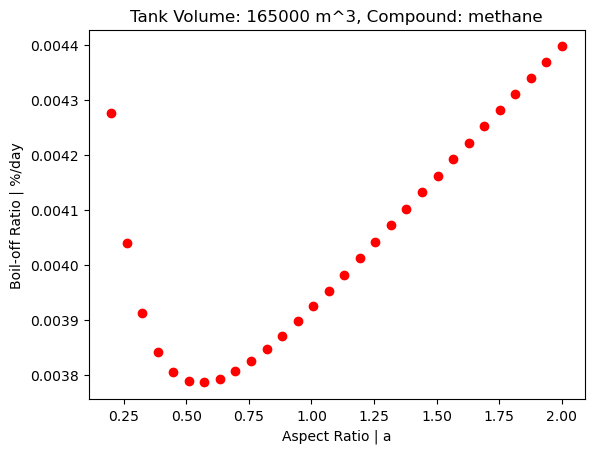

In [14]:
# Create a plot
plt.plot(AR, BOR_plot,"ro")

# Add labels and title
plt.xlabel('Aspect Ratio | a')
plt.ylabel('Boil-off Ratio | %/day')
plt.title(f'Tank Volume: {V_tank} m^3, Compound: {Compound}')


# Save the plot
plt.savefig(f'{Compound}/V_{V_tank}_LF_{LF*100}_C_{Compound}_final2.png')

# Display the plot
plt.show()